# PR on breast cancer dataset

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from io import StringIO
import requests
from sklearn import datasets
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix

from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [26]:
datab = load_breast_cancer()
df = pd.DataFrame(data=datab.data, columns=datab.feature_names)
df['class'] = [datab.target_names[i] for i in datab.target]
print(df.head())

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

In [27]:
print((df['class'] == 'malignant').sum())
print((df['class'] == 'benign').sum())

212
357


**Uncomment and run the following cell to make the dataset more imbalanced**

In [28]:
# malignant_rows = df[df['class'] == 'malignant']
# indexes_to_drop = malignant_rows.index[:150]
# df = df.drop(indexes_to_drop)
# print((df['class'] == 'malignant').sum())
# print((df['class'] == 'benign').sum())

In [29]:
df = df.replace('malignant', 1)
df = df.replace('benign', 0)
print(df["class"].unique())

[1 0]


/tmp/ipykernel_4126254/832030809.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('benign', 0)


---

In [30]:
X = df.drop('class', axis=1)  # Features
y = df['class']               # Target
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale the features to standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [32]:
# Predict probabilities for the test set
y_scores = model.predict_proba(X_test_scaled)[:, 1]
# Generate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

In [33]:
# Find the threshold that gives the best F1-score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1 = f1_scores[best_threshold_index]
# Print the best threshold and corresponding F1-score
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1-score: {best_f1:.2f}")

Best Threshold: 0.48
Best F1-score: 0.98


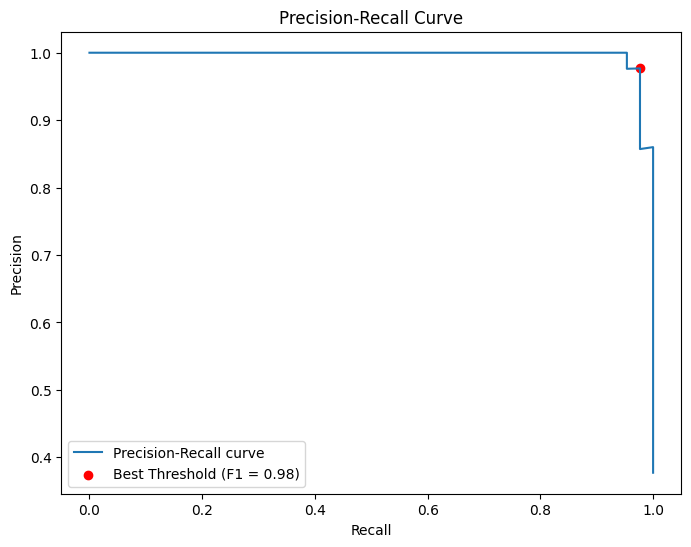

In [34]:
# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
# Plot the threshold points
plt.scatter(recall[best_threshold_index], precision[best_threshold_index], color='red', label=f'Best Threshold (F1 = {best_f1:.2f})')
plt.legend(loc='best')
plt.show()

In [35]:
# Evaluate the model using the best threshold
y_pred_best = (y_scores >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_best))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Confusion Matrix:
 [[70  1]
 [ 1 42]]


---

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.997


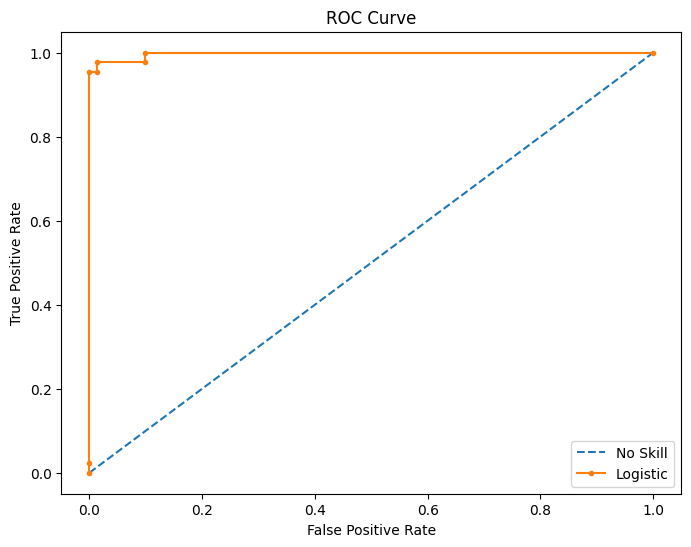

In [36]:
ns_probs = np.zeros_like(y_test)  # prédit toujours 0
lr_probs = model.predict_proba(X_test_scaled)[:, 1]  # bien utiliser X_test_scaled

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % ns_auc)
print('Logistic: ROC AUC=%.3f' % lr_auc)

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.figure(figsize=(8, 6))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()